[tensorboard](http://condor:6006)

In [1]:
import sys
sys.path.append('../python/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plots import availability_matrix as avail

In [384]:
%matplotlib nbagg

In [24]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

N - number of data points ('examples')   
D - dimensionality of input data   
K - dimensionality of principal component space
  
x1 - noisy data   
x - noiseless (in case of toy) or complete (in case of real) date

In [411]:
class data(object):
    def toy(self, N=5000, D=5, K=5, tau=1):
        w = np.random.normal(0, 1, (D, K)) # weights
        z = np.random.normal(0, 1, (K, N)) # components
        self.mu = np.random.normal(0, 1, (D, 1)) # means
        x = w.dot(z)
        self.x = pd.DataFrame(x + self.mu)
        self.tau = tau
        self.x1 = np.ma.masked_invalid(self.x + np.random.normal(0, tau, (D, N)))
        
        # apply PCA to rotate W and Z for later error computation
        e, v = np.linalg.eigh(np.cov(x))
        self.W = v[:, np.argsort(e)[::-1][:K]]
        self.Z = self.W.T.dot(x).T
        return self
    
    def real(self):
        t = pd.read_hdf('../../data/CEAZAMet/station_data.h5', 'ta_c').xs('prom', 1, 'aggr')[['3','4','5','8','9']]
        t.columns = t.columns.get_level_values(0)
        x = t.resample('D').mean()
        self.mask = pd.DataFrame(x.notnull(), index=x.index, columns=x.columns)
        self.x1 = np.ma.masked_invalid(x)
        # this is a fraction of the data without any missing values
        self.x = x[(x.index >= pd.Timestamp('2013')) & (x.index < pd.Timestamp('2017'))]
        return self
    
    def missing(self, frac, blocks=0):
        mask = np.ones(self.x.shape).flatten()
        n = int(round(frac * len(mask)))
        if blocks == 0:
            mask[np.random.choice(len(mask), n, replace=False)] = 0
        else:
            s = np.random.poisson(n / blocks, blocks) # block lengths
            i = np.random.choice(len(mask) - round(s.mean()), blocks, replace=False) # block start indexes
            for j, t in zip(i, s):
                mask[j: j + t] = 0
        mask = np.reshape(mask, self.x.shape, {0: 'F', 1:'C'}[np.argmax(self.x.shape)])
        self.mask = pd.DataFrame(mask, index=self.x.index, columns=self.x.columns)
        x1 = self.x * self.mask.replace(0, np.nan)
        self.x1 = np.ma.masked_invalid(x1)
        return self

In [311]:
t = data().real()

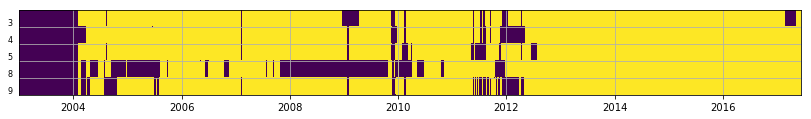

In [41]:
avail(t.mask, figsize=(14, 2), bottom=.4)

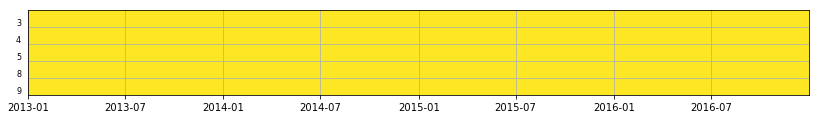

In [26]:
avail(t.x.notnull(), figsize=(14, 2), bottom=.4)

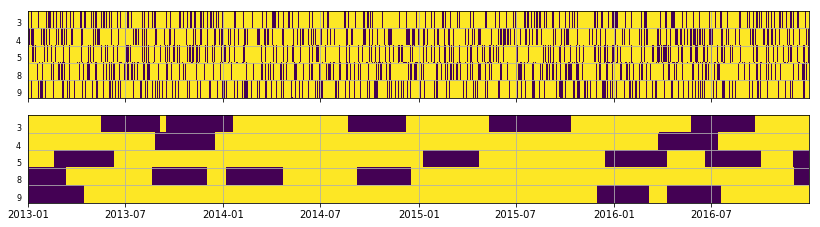

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(14, 3))
t.missing(.3)
avail(t.mask, axs[0])
t.missing(.3, 20)
avail(t.mask, axs[1], bottom=.1)
axs[0].set_xticklabels([]);

In [60]:
import ppca

In [61]:
from imp import reload

In [412]:
d = data().toy()

In [390]:
p1 = ppca.detPCA()
for mv in np.linspace(0, 1, 20):
    p1.run(d.missing(mv).x1).critique(d)

In [394]:
p2 = ppca.detPCA()
for mv in np.linspace(0, 1, 20):
    p2.run(d.missing(mv).x1, n_iter=10).critique(d)

In [299]:
reload(ppca)

<module 'ppca' from '../python/ppca.py'>

<IPython.core.display.Javascript object>


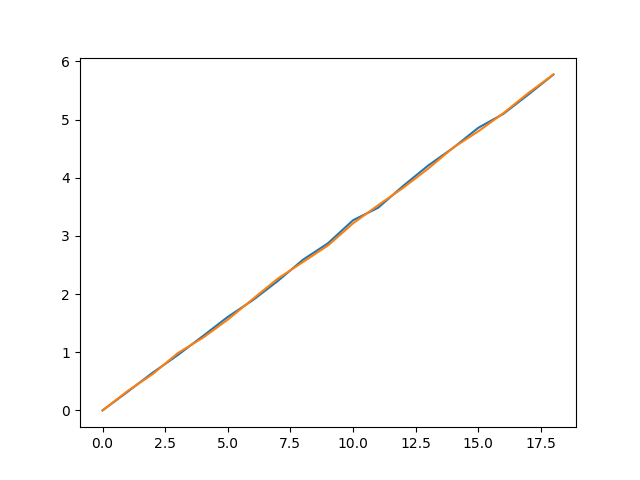

In [395]:
plt.figure()
plt.plot(p1.losses.x)
plt.plot(p2.losses.x)

In [543]:
p = ppca.probPCA(d.x1)

In [544]:
for _ in range(20):
    p.run(1000).critique(d)

1000/1000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 54877.375

data_loss: 0.6990610957145691
tau: 1.2627527713775635
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 54424.070

data_loss: 0.5850129127502441
tau: 1.1342427730560303
1000/1000 [100%] ██████████████████████████████ Elapsed: 19s | Loss: 54795.758

data_loss: 0.7515475749969482
tau: 1.326344609260559
1000/1000 [100%] ██████████████████████████████ Elapsed: 25s | Loss: 54370.027

data_loss: 0.5299170613288879
tau: 1.1016008853912354
1000/1000 [100%] ██████████████████████████████ Elapsed: 31s | Loss: 54485.867

data_loss: 0.6590101718902588
tau: 1.1631722450256348
1000/1000 [100%] ██████████████████████████████ Elapsed: 37s | Loss: 54387.773

data_loss: 0.6348138451576233
tau: 1.151620864868164
1000/1000 [100%] ██████████████████████████████ Elapsed: 43s | Loss: 55601.805

data_loss: 0.6171585917472839
tau: 1.2666287422180176
1000/1000 [100%] ██████████████████████████████ Elapsed: 49s | Lo

In [430]:
ppca.tf.get_variable_scope().reuse_variables()

In [542]:
reload(ppca)

<module 'ppca' from '../python/ppca.py'>

In [535]:
p.critique(d, rotate=True)


data_loss: 0.8624913096427917
tau: 1.4469279050827026


In [546]:
p.losses.mean()

W      0.084571
Z      1.266995
mu     0.001005
tau   -0.189893
x      0.665766
dtype: float64

In [540]:
p.logdir

In [ ]:
p.inference